In [1]:
#limiting the GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.60  # Set to 60% 
config.gpu_options.allow_growth = True

session = InteractiveSession(config=config)

2024-08-06 11:04:38.386990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 11:04:40.800654: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 11:04:41.923593: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 11:04:47.706432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

# root_directory = '/home/ms/Documents/Aditya/Experiment/sem_3/data/satellite/archive/Semantic segmentation dataset/Tile 1/'
root_directory = '/home/aditya/Documents/sem_3/dataset/weednet/Original_Image/'
patch_size = 256

Segmentation Models: using `tf.keras` framework.


In [3]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

image_dataset = []  
for path, subdirs, files in sorted(os.walk(root_directory)):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'img':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):   #Only read jpg images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

 
#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in sorted(os.walk(root_directory)):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'mask_png':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
       
image_dataset = np.array(image_dataset)   #PIL image object to numpy array            
mask_dataset =  np.array(mask_dataset)    #PIL image object to numpy array                    
                         
 

Now patchifying image: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/img/1.png
Now patchifying image: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/img/2.png
Now patchifying image: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/img/3.png
Now patchifying image: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/img/4.png
Now patchifying image: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/img/5.png
Now patchifying mask: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/mask_png/1.png
Now patchifying mask: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/mask_png/2.png
Now patchifying mask: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/mask_png/3.png
Now patchifying mask: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/mask_png/4.png
Now patchifying mask: /home/aditya/Documents/sem_3/dataset/weednet/Original_Image/mask_png/5.png


In [4]:
# #Read images from repsective 'images' subdirectory
# #As all images are of ddifferent size we have 2 options, either resize or crop
# #But, some images are too large and some small. Resizing will change the size of real objects.
# #Therefore, we will crop them to a nearest size divisible by 256 and then 
# #divide all images into patches of 256x256x3. 

# image_dataset = []  
# for path, subdirs, files in sorted(os.walk(root_directory)): 
#     dirname = path.split(os.path.sep)[-1]
#     if dirname == 'img':   #Find all 'images' directories
#         images = sorted(os.listdir(path))  #List of all image names in this subdirectory
#         for i, image_name in enumerate(images):  
#             if image_name.endswith(".png"):   #Only read jpg images...
               
#                 image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
#                 SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
#                 SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
#                 image = Image.fromarray(image)
#                 image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#                 #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
#                 image = np.array(image)             
       
#                 #Extract patches from each image
#                 print("Now patchifying image:", path+"/"+image_name)
#                 patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
#                 for i in range(patches_img.shape[0]):
#                     for j in range(patches_img.shape[1]):
                        
#                         single_patch_img = patches_img[i,j,:,:]
                        
#                         #Use minmaxscaler instead of just dividing by 255. 
#                         single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
#                         #single_patch_img = (single_patch_img.astype('float32')) / 255. 
#                         single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
#                         image_dataset.append(single_patch_img)
 
# #Now do the same as above for masks
# #For this specific dataset we could have added masks to the above code as masks have extension png
# mask_dataset = []  
# for path, subdirs, files in sorted(os.walk(root_directory)):
#     #print(path)  
#     dirname = path.split(os.path.sep)[-1]
#     if dirname == 'masks':   #Find all 'images' directories
#         masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
#         for i, mask_name in enumerate(masks):  
#             if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
#                 mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
#                 mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
#                 SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
#                 SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
#                 mask = Image.fromarray(mask)
#                 mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#                 #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
#                 mask = np.array(mask)             
       
#                 #Extract patches from each image
#                 print("Now patchifying mask:", path+"/"+mask_name)
#                 patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
#                 for i in range(patches_mask.shape[0]):
#                     for j in range(patches_mask.shape[1]):
                        
#                         single_patch_mask = patches_mask[i,j,:,:]
#                         #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
#                         single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
#                         mask_dataset.append(single_patch_mask) 
       
# image_dataset = np.array(image_dataset)   #PIL image object to numpy array            
# mask_dataset =  np.array(mask_dataset)    #PIL image object to numpy array                    
 

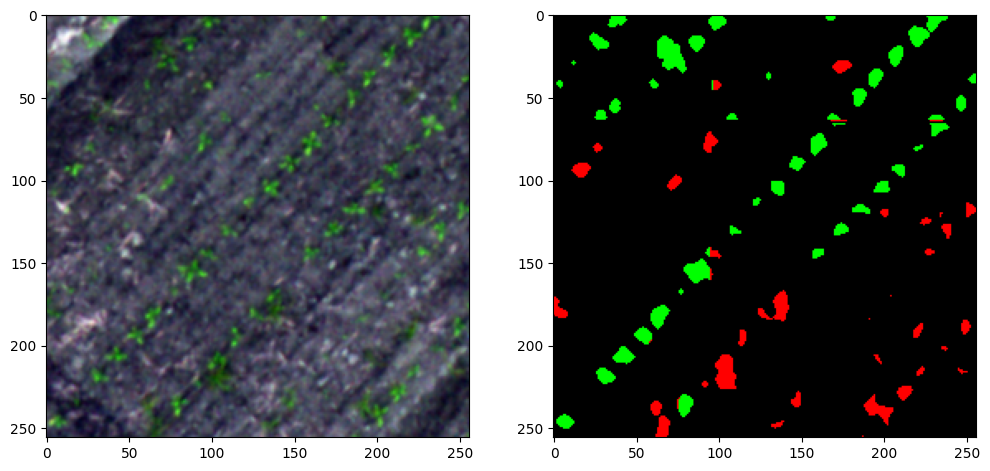

In [5]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [6]:
# Find unique colors in the mask dataset
unique_colors = np.unique(mask_dataset.reshape(-1, mask_dataset.shape[3]), axis=0)
num_unique_colors = unique_colors.shape[0]
print(f"Number of unique colors in the mask dataset: {num_unique_colors}")
print("Unique colors are:", unique_colors)

Number of unique colors in the mask dataset: 3
Unique colors are: [[  0   0   0]
 [  0 255   0]
 [255   0   0]]


In [7]:
# Directly pass the RGB values
class1 = np.array([0, 0, 0])
class2 = np.array([0, 255, 0])
class3 = np.array([255, 0, 0])
# class4 = np.array([226, 169, 41])
# class5 = np.array([254, 221, 58])
# class6 = np.array([155, 155, 155])

In [8]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == class1,axis=-1)] = 0
    label_seg [np.all(label==class2,axis=-1)] = 1
    label_seg [np.all(label==class3,axis=-1)] = 2
    # label_seg [np.all(label==class4,axis=-1)] = 3
    # label_seg [np.all(label==class5,axis=-1)] = 4
    # label_seg [np.all(label==class6,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [9]:

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2]


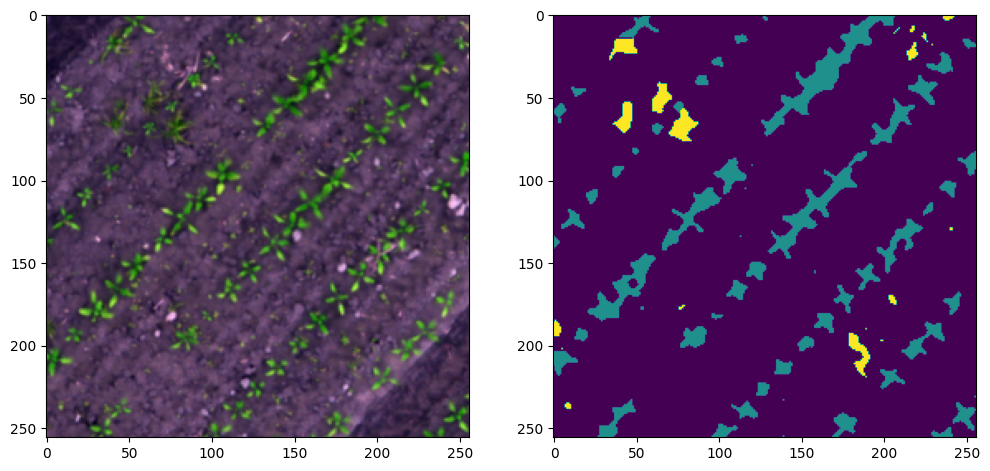

In [10]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [11]:
num_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=num_classes)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [13]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.3333, 0.3333, 0.3333]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [14]:
from simple_multi_unet_model_1 import multi_unet_model, jaccard_coef_multiclass ,dice_coef_multiclass,  mean_iou_multiclass

metrics=['accuracy', jaccard_coef_multiclass, dice_coef_multiclass , mean_iou_multiclass  ]

def get_model():
    return multi_unet_model(n_classes=num_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [15]:
# def jaccard_coef_multiclass(num_classes):
#     def jaccard_coef(y_true, y_pred):
#         y_true_f = K.argmax(y_true, axis=-1)
#         y_pred_f = K.argmax(y_pred, axis=-1)
#         jaccard = 0
#         for i in range(num_classes):
#             y_true_i = K.cast(K.equal(y_true_f, i), K.floatx())
#             y_pred_i = K.cast(K.equal(y_pred_f, i), K.floatx())
#             intersection = K.sum(y_true_i * y_pred_i)
#             union = K.sum(y_true_i) + K.sum(y_pred_i) - intersection
#             jaccard += (intersection + 1.0) / (union + 1.0)
#         return jaccard / num_classes
#     return jaccard_coef

# def mean_iou_multiclass(num_classes):
#     def mean_iou(y_true, y_pred):
#         y_true_f = K.argmax(y_true, axis=-1)
#         y_pred_f = K.argmax(y_pred, axis=-1)
#         iou = 0
#         for i in range(num_classes):
#             y_true_i = K.cast(K.equal(y_true_f, i), K.floatx())
#             y_pred_i = K.cast(K.equal(y_pred_f, i), K.floatx())
#             intersection = K.sum(y_true_i * y_pred_i)
#             union = K.sum(y_true_i) + K.sum(y_pred_i) - intersection
#             iou += (intersection + 1.0) / (union + 1.0)
#         return iou / num_classes
#     return mean_iou


# def mean_iou_multiclass(num_classes):
#     def mean_iou(y_true, y_pred):
#         y_true_f = K.argmax(y_true, axis=-1)
#         y_pred_f = K.argmax(y_pred, axis=-1)
#         iou = 0
#         for i in range(num_classes):
#             y_true_i = K.cast(K.equal(y_true_f, i), K.floatx())
#             y_pred_i = K.cast(K.equal(y_pred_f, i), K.floatx())
#             intersection = K.sum(y_true_i * y_pred_i)
#             union = K.sum(y_true_i) + K.sum(y_pred_i) - intersection
#             iou += (intersection + 1.0) / (union + 1.0)
#         return iou / num_classes
#     return mean_iou

In [16]:
model = get_model()

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        jaccard_coef_multiclass(num_classes), 
        dice_coef_multiclass(num_classes), 
        mean_iou_multiclass(num_classes)
    ]
)

# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


2024-08-06 11:11:22.207852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29204 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
#Another sanity check 
model.input_shape

(None, 256, 256, 3)

In [18]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1000, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

################################
# #Modelcheckpoint
# import tensorflow as tf
# EPOCHS = 10
# BATCH_SIZE = 16
# # checkpointer = tf.keras.callbacks.ModelCheckpoint('model_tray_tray.h5', verbose=1, save_best_only=True)

# # Define your callbacks
# checkpointer = tf.keras.callbacks.ModelCheckpoint('models/satellite_standard_unet_10epochs_25June2024.hdf5', verbose=1, save_best_only=True)
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

# # callbacks = [
# #         tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
# #         tf.keras.callbacks.TensorBoard(log_dir='logs')]

# # results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

# # Train the model with the specified callbacks
# history1 = model.fit(X_train, y_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpointer, early_stopping, tensorboard])

Epoch 1/1000


2024-08-06 11:11:32.804374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2024-08-06 11:11:33.834030: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-06 11:11:35.028648: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


115/115 [==============================] - 17s 83ms/step - loss: 0.2061 - jaccard_coef: 0.3218 - dice_coef: 0.3322 - mean_iou: 0.3218 - val_loss: 0.0768 - val_jaccard_coef: 0.3644 - val_dice_coef: 0.3989 - val_mean_iou: 0.3644
Epoch 2/1000
115/115 [==============================] - 7s 63ms/step - loss: 0.0771 - jaccard_coef: 0.4697 - dice_coef: 0.5299 - mean_iou: 0.4697 - val_loss: 0.0568 - val_jaccard_coef: 0.5024 - val_dice_coef: 0.5570 - val_mean_iou: 0.5024
Epoch 3/1000
115/115 [==============================] - 7s 64ms/step - loss: 0.0628 - jaccard_coef: 0.5053 - dice_coef: 0.5654 - mean_iou: 0.5053 - val_loss: 0.0511 - val_jaccard_coef: 0.5374 - val_dice_coef: 0.6078 - val_mean_iou: 0.5374
Epoch 4/1000
115/115 [==============================] - 7s 65ms/step - loss: 0.0560 - jaccard_coef: 0.5985 - dice_coef: 0.6954 - mean_iou: 0.5985 - val_loss: 0.0454 - val_jaccard_coef: 0.6558 - val_dice_coef: 0.7591 - val_mean_iou: 0.6558
Epoch 5/1000
115/115 [==============================] - 

In [19]:
model.save('models/weednet_crop_weed_update_epochs1000.hdf5')


In [20]:
# # Find unique colors in the mask dataset
# unique_colors = np.unique(mask_dataset.reshape(-1, mask_dataset.shape[3]), axis=0)
# num_unique_colors = unique_colors.shape[0]
# print(f"Number of unique colors in the mask dataset: {num_unique_colors}")

# # Create a mapping from unique colors to integer labels
# color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# # Function to convert RGB mask to integer labels
# def rgb_to_2D_label(label):
#     """
#     Convert RGB mask to 2D label mask.
#     """
#     label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
#     for color, label_id in color_to_label.items():
#         label_seg[np.all(label == color, axis=-1)] = label_id
#     return label_seg

# # Apply the function to all masks in the dataset
# labels = []
# for i in range(mask_dataset.shape[0]):
#     label = rgb_to_2D_label(mask_dataset[i])
#     labels.append(label)    

# labels = np.array(labels)   
# labels = np.expand_dims(labels, axis=3)

# print("Unique labels in label dataset are: ", np.unique(labels))

In [21]:

# # Find unique colors in the mask dataset
# unique_colors = np.unique(mask_dataset.reshape(-1, mask_dataset.shape[3]), axis=0)
# num_unique_colors = unique_colors.shape[0]

# print(f"Number of unique colors in the mask dataset: {num_unique_colors}")

In [22]:
# """
# RGB to HEX: (Hexadecimel --> base 16)
# This number divided by sixteen (integer division; ignoring any remainder) gives 
# the first hexadecimal digit (between 0 and F, where the letters A to F represent 
# the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
# 0-9 --> 0-9
# 10-15 --> A-F

# Example: RGB --> R=201, G=, B=

# R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

# Calculating RGB from HEX: #3C1098
# 3C = 3*16 + 12 = 60
# 10 = 1*16 + 0 = 16
# 98 = 9*16 + 8 = 152

# """
# #Convert HEX to RGB array
# # Try the following to understand how python handles hex values...
# a=int('3C', 16)  #3C with base 16. Should return 60. 
# print(a)
# #Do the same for all RGB channels in each hex code to convert to RGB
# Building = '#3C1098'.lstrip('#')
# Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

# Land = '#8429F6'.lstrip('#')
# Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

# Road = '#6EC1E4'.lstrip('#') 
# Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

# Vegetation =  'FEDD3A'.lstrip('#') 
# Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

# Water = 'E2A929'.lstrip('#') 
# Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

# Unlabeled = '#9B9B9B'.lstrip('#') 
# Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

# label = single_patch_mask

In [23]:
# # Now replace RGB to integer values to be used as labels.
# #Find pixels with combination of RGB for the above defined arrays...
# #if matches then replace all values in that pixel with a specific integer
# def rgb_to_2D_label(label):
#     """
#     Suply our labale masks as input in RGB format. 
#     Replace pixels with specific RGB values ...
#     """
#     label_seg = np.zeros(label.shape,dtype=np.uint8)
#     label_seg [np.all(label == Building,axis=-1)] = 0
#     label_seg [np.all(label==Land,axis=-1)] = 1
#     label_seg [np.all(label==Road,axis=-1)] = 2
#     label_seg [np.all(label==Vegetation,axis=-1)] = 3
#     label_seg [np.all(label==Water,axis=-1)] = 4
#     label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
#     label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
#     return label_seg


In [24]:

# labels = []
# for i in range(mask_dataset.shape[0]):
#     label = rgb_to_2D_label(mask_dataset[i])
#     labels.append(label)    

# labels = np.array(labels)   
# labels = np.expand_dims(labels, axis=3)
 

# print("Unique labels in label dataset are: ", np.unique(labels))

In [25]:
# #Another Sanity check, view few mages
# import random
# import numpy as np
# image_number = random.randint(0, len(image_dataset))
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(image_dataset[image_number])
# plt.subplot(122)
# plt.imshow(labels[image_number][:,:,0])
# plt.show()


In [26]:
# n_classes = len(np.unique(labels))
# n_classes

In [27]:

# n_classes = len(np.unique(labels))
# from keras.utils import to_categorical
# labels_cat = to_categorical(labels, num_classes=n_classes)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [28]:
# #Parameters for model
# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# # set class weights for dice_loss
# # from sklearn.utils.class_weight import compute_class_weight

# # weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
# #                               np.ravel(labels,order='C'))
# # print(weights)

# weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# dice_loss = sm.losses.DiceLoss(class_weights=weights) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)  #


# IMG_HEIGHT = X_train.shape[1]
# IMG_WIDTH  = X_train.shape[2]
# IMG_CHANNELS = X_train.shape[3]

In [29]:
# from simple_multi_unet_model import multi_unet_model, jacard_coef  

# metrics=['accuracy', jacard_coef]

# def get_model():
#     return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [30]:
# model = get_model()
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
# #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
# model.summary()


In [31]:
# #Another sanity check 
# model.input_shape

In [32]:
# history1 = model.fit(X_train, y_train, 
#                     batch_size = 16, 
#                     verbose=1, 
#                     epochs=10, 
#                     validation_data=(X_test, y_test), 
#                     shuffle=False)

# ################################
# # #Modelcheckpoint
# # import tensorflow as tf
# # EPOCHS = 10
# # BATCH_SIZE = 16
# # # checkpointer = tf.keras.callbacks.ModelCheckpoint('model_tray_tray.h5', verbose=1, save_best_only=True)

# # # Define your callbacks
# # checkpointer = tf.keras.callbacks.ModelCheckpoint('models/satellite_standard_unet_10epochs_25June2024.hdf5', verbose=1, save_best_only=True)
# # early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# # tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

# # # callbacks = [
# # #         tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
# # #         tf.keras.callbacks.TensorBoard(log_dir='logs')]

# # # results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

# # # Train the model with the specified callbacks
# # history1 = model.fit(X_train, y_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpointer, early_stopping, tensorboard])

In [33]:

# model.save('models/satellite_standard_unet_2000epochs.hdf5')

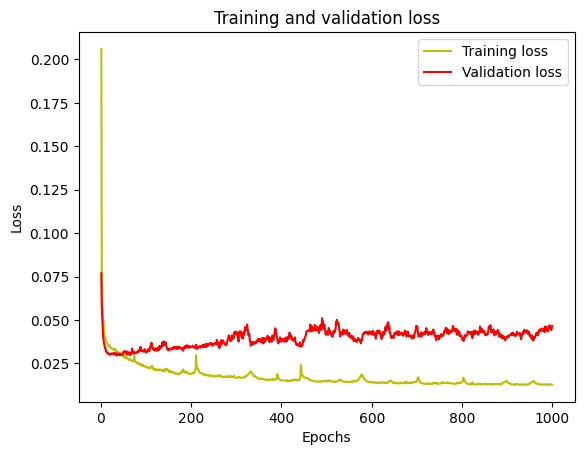

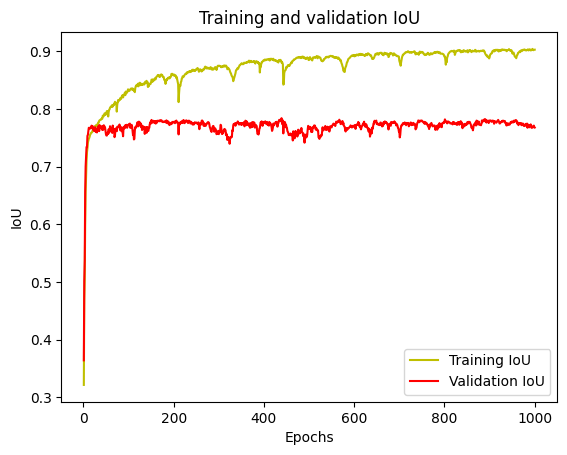

In [34]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [35]:
# from keras.models import load_model
# model = load_model("models/satellite_standard_unet_100epochs.hdf5"
#                    custom_objects={'dice_loss_plus_2focal_loss': total_loss,
#                                    'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = num_classes
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


15/15 [==============================] - 1s 28ms/step
Mean IoU = 0.7699921


In [36]:
from sklearn.metrics import jaccard_score, f1_score 
from keras import backend as K

# Get predictions for the test data
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_test_argmax = np.argmax(y_test, axis=-1)

# Jaccard Index (IoU) for each class
iou_keras = MeanIoU(num_classes=num_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())

# Jaccard Index using sklearn
iou_per_class = jaccard_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average=None)
print("IoU per class:", iou_per_class)

# Dice Coefficient (F1 Score) for each class
dice_per_class = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average=None)
print("Dice Coefficient per class:", dice_per_class)

# Mean IoU from the custom metric
mean_iou_value = mean_iou_multiclass(num_classes)(K.variable(y_test), K.variable(y_pred))
print("Mean IoU (custom metric) =", K.eval(mean_iou_value))

# Jaccard Index from the custom metric
jaccard_value = jaccard_coef_multiclass(num_classes)(K.variable(y_test), K.variable(y_pred))
print("Jaccard Coefficient (custom metric) =", K.eval(jaccard_value))

# Dice Coefficient from the custom metric
dice_value = dice_coef_multiclass(num_classes)(K.variable(y_test), K.variable(y_pred))
print("Dice Coefficient (custom metric) =", K.eval(dice_value))


15/15 [==============================] - 0s 29ms/step
Mean IoU = 0.7699921
IoU per class: [0.989627   0.74315039 0.58451399]
Dice Coefficient per class: [0.99478646 0.85265207 0.73778331]
Mean IoU (custom metric) = 0.7724309
Jaccard Coefficient (custom metric) = 0.7724309
Dice Coefficient (custom metric) = 0.8617408


1/1 [==============================] - 0s 209ms/step


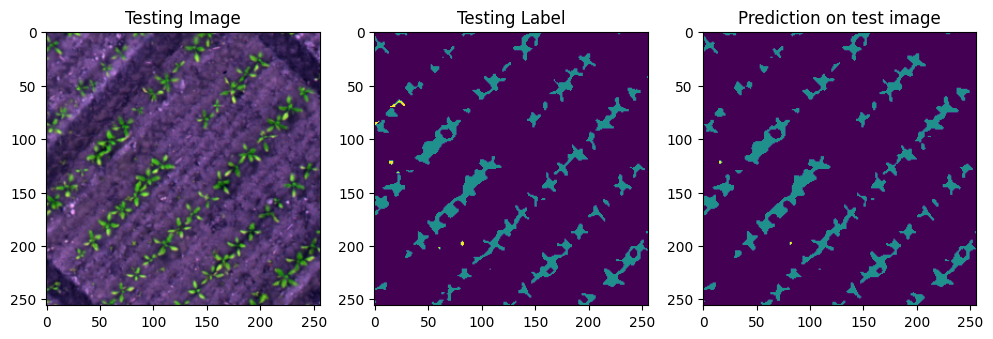

: 

In [37]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()